In [1]:
%matplotlib inline
import numpy as N
import scipy.sparse as sp
from scipy.integrate import ode
import matplotlib.pyplot as plt

/home/marek/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def species(soubor):
        species = file(soubor,"r")
        conc = []  # speci
        pomoc = {}
        index = 0
        for line in species:
            try:     
                name, init_conc = line.split()
                pomoc[name] = index
                conc.append(float(init_conc))  
                index += 1
            except: continue   
        species.close()
        conc = N.array(conc)
        
        return conc, pomoc        

In [3]:
def reactions(soubor, pomoc):
    reaction = file(soubor,"r")
    index = 0
    k_c = []
    REACT = []
    PROD = []
    for line in reaction:
        try:
            rovnice = line.split()
            k_c.append(float(rovnice[0]))
            rozdel = rovnice.index("=>")
            pozn = rovnice.index("//")
            
            reactant=(rovnice[1:rozdel])
            product=(rovnice[rozdel+1:pozn])
            REACTp = N.zeros(len(pomoc),int)
            PRODp = N.zeros(len(pomoc),int)
        except: continue
        for i in range(len(reactant)):
            if (REACTp[pomoc[reactant[i]]] == 0):      # - zbytecna podminka .. ?
                j = reactant.count(reactant[i])
                REACTp[pomoc[reactant[i]]] = j
        REACT.append(REACTp)
        for i in range(len(product)):
            if (PRODp[pomoc[product[i]]] == 0):      # - zbytecna podminka .. ?
                j = product.count(product[i])
                PRODp[pomoc[product[i]]] = j
        PROD.append(PRODp)
        index += 1
    
    reaction.close()
    k_c = N.array(k_c)
    REACT = N.array(REACT)
    PROD = N.array(PROD)
    Z = PROD - REACT
    REACT = sp.csr_matrix(REACT)
    
    POSITIV =  N.zeros((len(k_c),len(pomoc)), dtype = int)     # pro testovani
    NEGATIV =  N.zeros((len(k_c),len(pomoc)), dtype = int)     # pro testovani

    for i in range(len(k_c)):
        for j in range(len(pomoc)):
            if Z[i][j] < 0: 
                NEGATIV[i][j] = Z[i][j]
            else: POSITIV[i][j] = Z[i][j]
                    
    NEGATIV = N.transpose(NEGATIV)
    NEGATIV = sp.csr_matrix(NEGATIV)
    POSITIV = N.transpose(POSITIV)
    POSITIV = sp.csr_matrix(POSITIV)

    Z = N.transpose(Z)      #/ csr_matrix.getH(Z)
    Z = sp.csr_matrix(Z)                    
    
    return k_c, REACT, Z, NEGATIV, POSITIV

In [4]:
def create_ODE(t, concentration, k_c, Z, REACT, POSITIV, NEGATIV, ind_vyvoj):
    # sestaveni rovnice pro resic lsoda; nevyzaduje vypocet jakobianu 
   
    f = N.log(concentration)
    f = REACT * f
    f = N.exp(f)
    f = N.multiply(f,k_c)
    
    """                         # ind_vyvoj, podminka pro tisk hodnot
    print POSITIV * f
    print
    print NEGATIV * f
    print
    print
    """
    f = Z * f        
    return f

In [5]:
def solve_ODE(file_species, file_reactions, t1, dt):

    t0 = 0
    y0, pomoc = species(file_species)
    k_c, REACT, Z, NEGATIV, POSITIV = reactions(file_reactions, pomoc)
    ind_vyvoj = 0
    vyvoj = [y0]
    cas = [0]   
    r = ode(create_ODE).set_integrator('lsoda')
    r.set_initial_value(y0, t0).set_f_params(k_c, Z, REACT, POSITIV, NEGATIV, ind_vyvoj)
    #t1 = 20e-3
    #dt = t1 / 10e7          
    #ind = 0
    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        # print r.t,r.y
        #ind += 1
        cas.append(r.t)
        vyvoj.append(r.y)
        #if ():
        #if ind == 1:
            #break
    vyvoj = N.array(vyvoj)
    cas = N.array(cas)
    return r, pomoc, cas, vyvoj

In [6]:
file_species = "data/speci.txt"
file_reactions = "data/reakce.txt"
time = 20e-3
time_step = time/10e3
concentrations, pomoc, cas, vyvoj = solve_ODE(file_species, file_reactions, time, time_step)
#concentrations, pomoc = solve_ODE(file_species, file_reactions, time, time_step)

/home/marek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [7]:
for i in pomoc.keys():
    print i, ": \t  ", concentrations.y[pomoc[i]]

e- : 	   5.6342075612e+17
He2+ : 	   3.77578107661e+17
He(1s2s) : 	   1.00185996914e+12
Ar+ : 	   582527841370.0
H2 : 	   0.078122959046
H3+ : 	   1.82703466478e-05
H- : 	   50449.2141499
H2wall : 	   0.0
H+ : 	   376855399925.0
HeH+ : 	   1.88127127423e+15
Ar : 	   3.42107945661e-07
H2+ : 	   0.091562894576
H : 	   23398162391.9
He+ : 	   1.8396005933e+17
ArH+ : 	   358472158630.0
He : 	   1.4522143626e+12


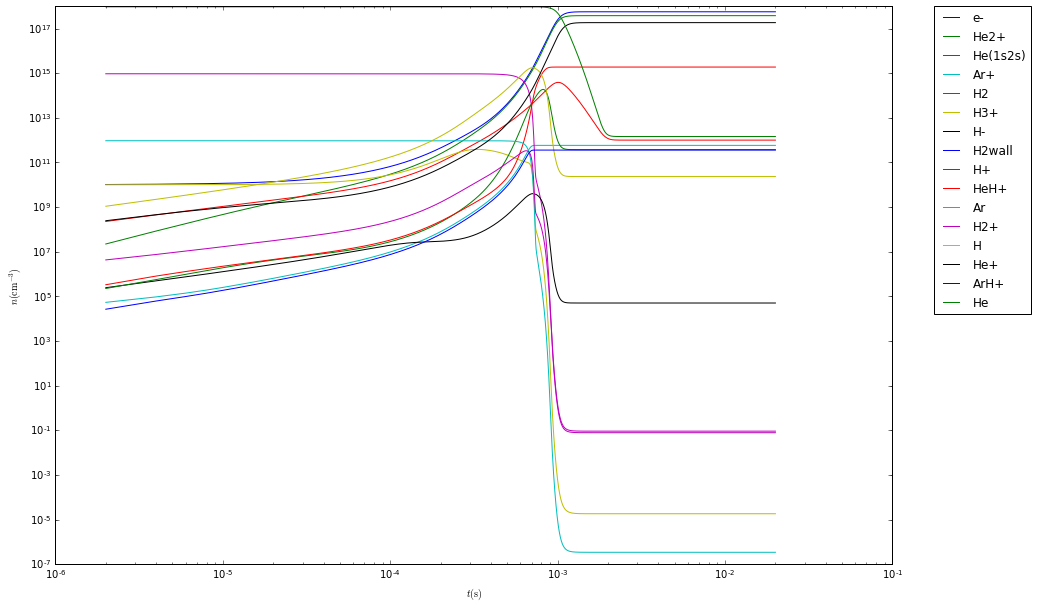

In [23]:
plt.figure(figsize=(15, 10))
for i in pomoc.keys():
    plt.loglog(cas[:], vyvoj[:,pomoc[i]], label = i)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r"$t (\rm s)$")
plt.ylabel(r"$n (\rm cm^{-3})$")